In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m'].sort_index()

mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m'].sort_index()

mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m'].sort_index()

In [3]:
def CIR_path(r0, days, theta, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    theta = theta
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a * (theta - r[t-1]) * dt + vol * rand[t] * np.sqrt(dt * r[t - 1])
    CIR = pd.DataFrame(r[:, 0], columns=['index'])
    CIR = CIR.values.flatten()
    return CIR


def CIR_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated CIR Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(CIR_path(data[0], len(data), opt[0], opt[1],
                      opt[2]), lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()
    


def CIR_ml_final_diff(p0, penalty=np.inf):
    theta, a, vol = p0
    if theta <= 0 or vol <= 0 or a <= 0 :
        return penalty 
    x = data
    dx = np.diff(data)
    dt = np.array([1/252]*len(dx))
    #dt = np.array([1]*len(dx))
    
    mu = a * (theta - x[:-1]) * dt 
    sigma = vol * np.sqrt(dt * x[:-1])
    
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [8]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def C0_ecdf_dist(f1, f2):
    xs1, ys1 = ecdf(f1)
    xs, ys = ecdf(f2)
    minv = np.minimum(xs1[0], xs[0]) - 0.001
    maxv = np.maximum(xs1[-1], xs[-1]) + 0.001

    xs = np.insert(xs, 0, minv)
    xs1 =  np.insert(xs1, 0 , minv)
    xs1 = np.insert(xs1, len(xs1), maxv)
    xs = np.insert(xs, len(xs), maxv)

    ys = np.insert(ys, 0, 0)
    ys = np.insert(ys, len(ys)-1, 1)
    ys1 = np.insert(ys1, 0, 0)
    ys1 = np.insert(ys1, len(ys)-1, 1)
    f = np.zeros(len(xs1))
    for i in range(len(xs1)):
        if xs[i] == xs1[i]:
            f[i] = np.abs(ys1[i]-ys[i])
        else: 
            temp = xs1[i] <xs
            f[i] = np.abs(ys1[i] - ys[temp.argmax()-1])
    return np.max(f)

def mean_C0(opt, n_path=100):
    t = []
    for i in range(n_path):
        t.append(C0_ecdf_dist(data, CIR_path(data[0], len(data), opt[0], opt[1], opt[2])))
    return np.mean(t)

def mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.max(np.abs(data - CIR_path(data[0], len(data), opt[0], opt[1], opt[2]))))
    return np.mean(dist)

In [9]:
data = mosprime3m_short

In [ ]:
p3 = np.array([np.median(data),  max(data) - min(data) , np.sqrt(data.var())])

Optimization terminated successfully.
         Current function value: -205.183684
         Iterations: 20
         Function evaluations: 38
[ 8.46510156  0.73101524  0.20067571]
Среднее максимальное расстояние между траекториями:  0.532508321788
Среднее С0 расстояние между функциями распределения: 0.558095238095
Правдоподобие: 205.183683624


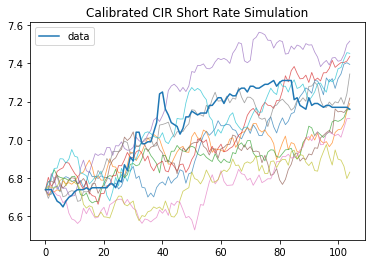

In [273]:
CIR_ml = sop.fmin(CIR_ml_final_diff, p3,
                        maxiter=100, maxfun=100, xtol=0.1, ftol=0.1)

print(CIR_ml)
print('Среднее максимальное расстояние между траекториями: ',mean_max_dist(CIR_ml, data, num_paths=10))
print('Среднее С0 расстояние между функциями распределения:' , mean_C0(CIR_ml, n_path=10))
print('Правдоподобие:' ,CIR_ml_lk(CIR_ml))
CIR_p(data, CIR_ml, num_paths=10)

In [283]:
class CIR_model():
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-6):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """

        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.w_all = None
        self.time_iter = None
        self.lk = None

    def fit(self, X):
        from scipy.special import expit
        import numpy as np
        import time
        self.time_iter = []
        self.loss_history = []
        w_i = self.w0
        lasttime = 0
        alltime = 0
        self.norm_hist = []
        self.lk = []
        self.w_all = []
        
        def CIR_ml_lk(p0):
            theta, a, vol = p0
            x = X
            dx = np.diff(X)
            dt = np.array([1/252]*len(dx))
            #dt = np.array([1]*len(dx))

            mu = a * (theta - x[:-1]) * dt 
            sigma = vol * np.sqrt(dt * x[:-1])

            const = -1/2 * len(dx) * np.log(2 * np.pi)
            sum1 = - np.sum(np.log(sigma))
            sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
            L = (const + sum1 + sum2)
            return L

        def CIR_ML_grad(z):
            theta, a, vol = z
            x = X
            dx = np.diff(X)
            dt = np.array([1/252]*len(dx))
            #dt = np.array([1]*len(dx))

            mu = a * (theta - x[:-1]) * dt 
            sigma = vol * np.sqrt(dt * x[:-1])


            L_vol = np.sum(
                (-1/sigma-(dx - mu)**2/sigma**3)*(np.sqrt(dt * x[:-1]))
            )

            L_a = np.sum(
                ((dx - mu)**2/sigma**2)*((theta - x[:-1]) * dt )
            )

            L_theta = np.sum(
                ((dx - mu)**2/sigma**2)*( a * dt )
            )

            return np.array([L_theta, L_a, L_vol])
        
        def nu(iter, typ):
            if typ == 'full':
                step = self.alpha
            else:
                step = self.alpha/((iter + 1)**(0.5))
            return step 
        
        for i in range(self.max_iter):
            start = time.time()
            w_old = w_i
            #w_i = w_old - nu(iter=i, typ=self.gd_type)*CIR_ML_grad(z = w_old)
            w_i = w_old + nu(iter=i, typ='full')*CIR_ML_grad(z = w_old)
            delta = (w_old - w_i)
            self.norm_hist.append(np.sum(delta**2))
            self.w = w_i
            #self.w_all.append(w_i)
            end = time.time()
            lasttime = start - end
            alltime = alltime + lasttime
            self.time_iter.append(alltime)
            l_h = CIR_ml_lk(p0=w_i)
            self.lk.append(l_h)
            if np.sqrt(np.sum(delta**2)) <= self.tolerance:
                break
        pass
        #self.w = self.w_all[np.argmax(self.lk)]
        return self


    def calc_lh(self, X):
        def CIR_ml_lk(p0):
            theta, a, vol = p0
            x = X
            dx = np.diff(X)
            dt = np.array([1/252]*len(dx))
            #dt = np.array([1]*len(dx))

            mu = a * (theta - x[:-1]) * dt 
            sigma = vol * np.sqrt(dt * x[:-1])

            const = -1/2 * len(dx) * np.log(2 * np.pi)
            sum1 = - np.sum(np.log(sigma))
            sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
            L = (const + sum1 + sum2)
            return L

        if len(X) == 0:
            raise Exception('X is empty')
        else:
            if self.w is None:
                raise Exception('Not trained yet')
            else:
                l_h = CIR_ml_lk(p0=self.w)
        return l_h
        pass



In [284]:
len(data)

252

In [285]:
p1 = np.array([0.01, 0.01, 0.01])
p2 = np.array([0.1,  0.1, 0.1])
p4 = np.array([40, 2, 1])

theta0: 7.15, a0: 0.6599999999999993, vol0: 0.21248973256815584
theta: 7.150109886571219, a: 0.6600192890738729, vol: -2.023108841447463
Среднее максимальное расстояние между траекториями:  3.67190021596
Среднее С0 расстояние между функциями распределения: 0.660952380952
Правдоподобие: 204.464061295


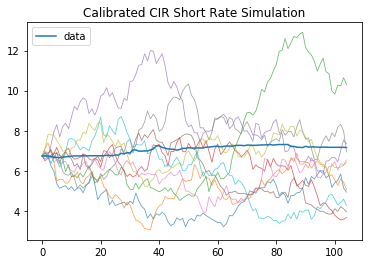

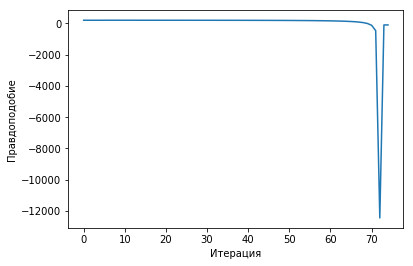

In [295]:
data = mosprime3m_short
p3 = np.array([np.median(data),  max(data) - min(data) , np.sqrt(data.var())])
CIR_ml_gf = CIR_model(w0=p3, max_iter=100, alpha=0.000001, tolerance=1e-4)
CIR_ml_gf.fit(data)

print("theta0: {theta}, a0: {a}, vol0: {vol}".format(theta = p3[0], a = p3[1], vol = p3[2]))
print("theta: {theta}, a: {a}, vol: {vol}".format(theta = CIR_ml_gf.w[0], a = CIR_ml_gf.w[1], vol = CIR_ml_gf.w[2]))
print('Среднее максимальное расстояние между траекториями: ',mean_max_dist(CIR_ml_gf.w, data, num_paths=10))
print('Среднее С0 расстояние между функциями распределения:' , mean_C0(CIR_ml_gf.w, n_path=10))
print('Правдоподобие:' , np.max(CIR_ml_gf.lk))
CIR_p(data, CIR_ml_gf.w, num_paths=10)
plt.show()

plt.plot(CIR_ml_gf.lk)
plt.xlabel('Итерация')
plt.ylabel('Правдоподобие')
plt.show()

In [288]:
 
def CIR_ml_lk(p0):
    theta, a, vol = p0
    X = data
    x = X
    dx = np.diff(X)
    dt = np.array([1/252]*len(dx))

    mu = a * (theta - x[:-1]) * dt 
    sigma = vol * np.sqrt(dt * x[:-1])

    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = (const + sum1 + sum2)
    return L

Среднее максимальное расстояние между траекториями:  0.59536496939
Среднее С0 расстояние между функциями распределения: 0.635742857143
Правдоподобие: 204.464061295


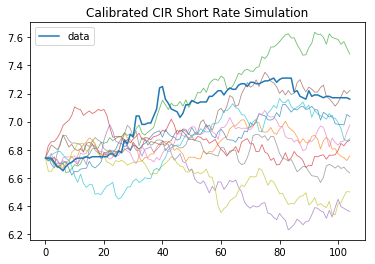

In [289]:
print('Среднее максимальное расстояние между траекториями: ',mean_max_dist(CIR_ml_gf.w, data, num_paths=10))
print('Среднее С0 расстояние между функциями распределения:' , mean_C0(CIR_ml_gf.w, n_path=1000))
print('Правдоподобие:' ,CIR_ml_lk(CIR_ml_gf.w))
CIR_p(data, CIR_ml_gf.w, num_paths=10)


In [290]:
def rolling_CIR(db=mosprime3m, periods=21):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    #end_dates = pd.date_range(start=date_start_end, end = db.index.max(), freq='d').strftime('%Y-%m-%d')
    #end_dates = [i for i in end_dates if i in db.index]
    df_cal_CIR = pd.DataFrame(columns=["theta", "alpha", "vol", "mean", "median", "std"], index=np.array(db.index[periods:]))
    for i in tqdm(range(len(df_cal_CIR))):
        global data
        data = db.dropna().values[i:(periods+i)]
        x = data
        median = np.median(x)
        mean = np.mean(x)
        std = np.std(x)
        p4 = [median, np.max(x)-np.min(x), std]#db252_HW1.values[i,:3]
        CIR_ml_gf = CIR_model(w0=p4, max_iter=10, alpha=0.000001)
        CIR_ml_gf.fit(data)
        df_cal_CIR.iloc[i] = np.append(CIR_ml_gf.w, [mean, median, std])
    return df_cal_CIR

In [291]:
db252_CIR = rolling_CIR(periods=252)

100%|██████████| 2469/2469 [00:07<00:00, 318.31it/s]


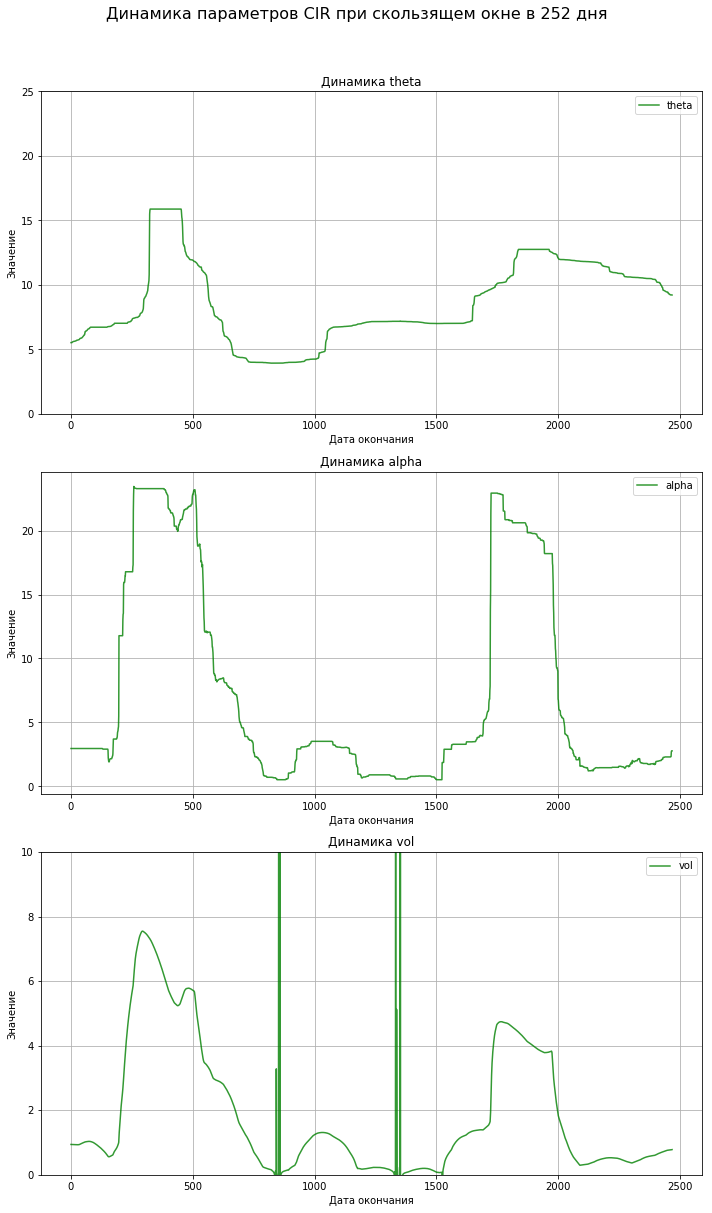

In [294]:
plt.figure(figsize=[10,16])
plt.subplot(3,1,1)
plt.plot(db252_CIR['theta'].values , 'g-',  alpha = 0.8, label = 'theta')
plt.title('Динамика theta')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.ylim([0,25])
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(db252_CIR['alpha'].values , 'g-',  alpha = 0.8, label = 'alpha')
plt.title('Динамика alpha')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(db252_CIR['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.ylim([0,10])
plt.legend()
plt.grid()


plt.suptitle('Динамика параметров CIR при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [293]:
a = np.array(db252_CIR['alpha'].values, dtype=float)
l = np.array(db252_CIR['theta'].values, dtype=float)
vol = np.array(db252_CIR['vol'].values, dtype=float)

x = mosprime3m.values[:-252]

t252 = np.array([252/252]*len(a))
sigma252 = np.sqrt(x * vol**2/a * (np.exp(- a * t252) - np.exp(- 2 * a * t252)) + l * vol**2/(2 * a) * (1 - np.exp(- a * t252))**2)
mu252 = x * np.exp(-a * t252) + l * (1 - np.exp(-a * t252))

t1 = np.array([1/252]*len(a))
sigma1 = np.sqrt(x * vol**2/a * (np.exp(- a * t1) - np.exp(- 2 * a * t1)) + l * vol**2/(2 * a) * (1 - np.exp(- a * t1))**2)
mu1 = x * np.exp(-a * t1) + l * (1 - np.exp(-a * t1))

t21 = np.array([21/252]*len(a))
sigma21 = np.sqrt(x * vol**2/a * (np.exp(- a * t21) - np.exp(- 2 * a * t21)) + l * vol**2/(2 * a) * (1 - np.exp(- a * t21))**2)
mu21 = x * np.exp(-a * t21) + l * (1 - np.exp(-a * t21))

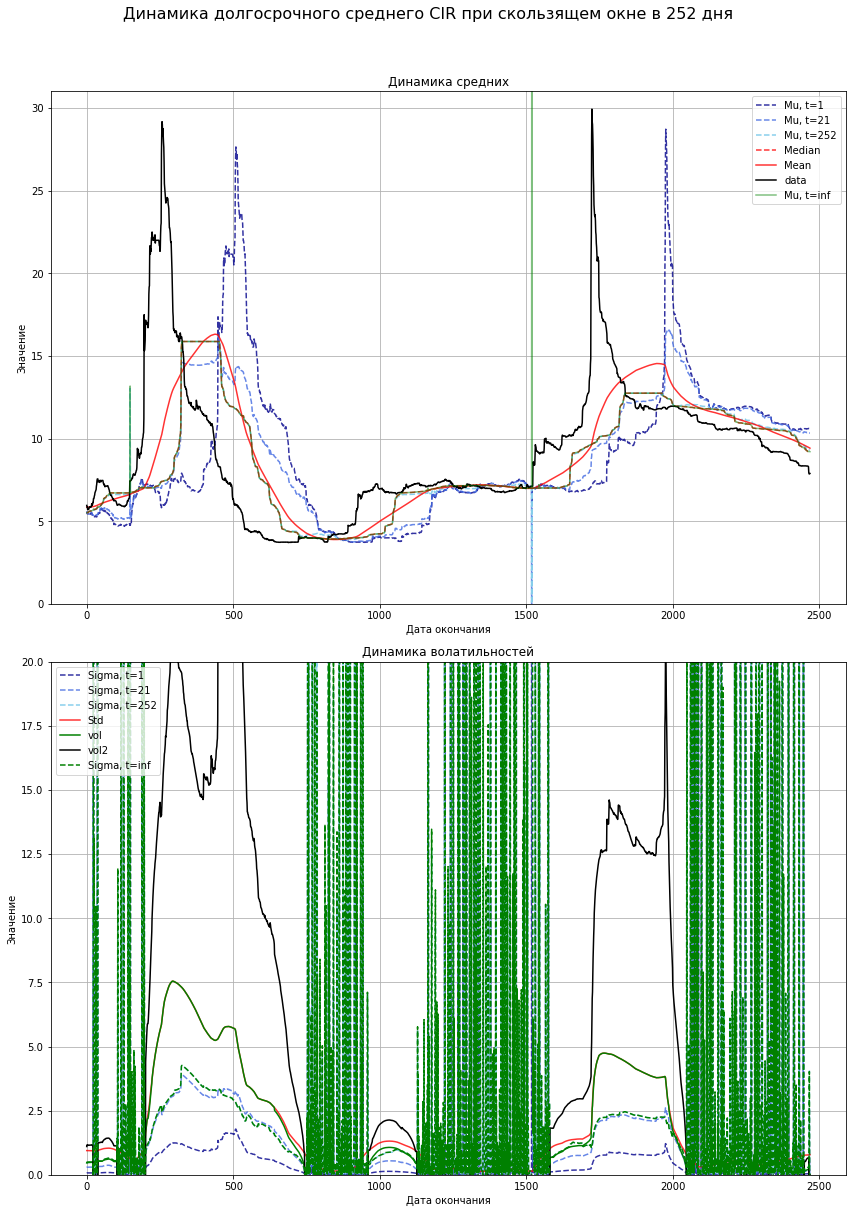

In [280]:
plt.figure(figsize=[12,16])

plt.subplot(2,1,1)
plt.plot(mu1 , '--', color='darkblue',  alpha = 0.8, label = 'Mu, t=1')
plt.plot(mu21 , '--', color='royalblue',  alpha = 0.8, label = 'Mu, t=21')
plt.plot(mu252 , '--', color='skyblue',  alpha = 2, label = 'Mu, t=252')
plt.plot(db252_CIR['median'].values , 'r--',  alpha = 0.8, label = 'Median')
plt.plot(db252_CIR['mean'].values , 'r-',  alpha = 0.8, label = 'Mean')
plt.plot(mosprime3m.values[252:] , 'black', label = 'data')
plt.plot(l , 'g-',  alpha = 0.5, label = 'Mu, t=inf')
plt.title('Динамика средних')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.ylim([0,31])
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(sigma1 , '--', color='darkblue',  alpha = 0.8, label = 'Sigma, t=1')
plt.plot(sigma21 , '--', color='royalblue',  alpha = 0.8, label = 'Sigma, t=21')
plt.plot(sigma252 ,'--', color='skyblue',  alpha = 2, label = 'Sigma, t=252')
plt.plot(db252_CIR['std'].values , 'r-',  alpha = 0.8, label = 'Std')
plt.plot(db252_CIR['vol'].values , 'g-',  alpha = 1, label = 'vol')
plt.plot(np.sqrt(x) * db252_CIR['vol'].values , 'k-',  alpha = 1, label = 'vol2')
plt.plot( np.sqrt(l * vol**2/(2 * a)) , 'g--',  alpha = 1, label = 'Sigma, t=inf')

plt.title('Динамика волатильностей')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.ylim([0,20])
plt.legend()
plt.grid()

plt.suptitle('Динамика долгосрочного среднего CIR при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

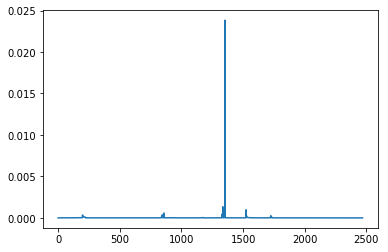

In [249]:
plt.plot(l-db252_CIR['median'].values)
plt.show()